In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

In [2]:
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download.")

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import importTensorflow, unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, calculate_results

[INFO] 'helper_functions.py' already exists, skipping download.


In [3]:
importTensorflow(memory=4090, precision=True)

2.13.0
1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
<Policy "mixed_float16">


We will be using RNN to train textual information

**Basic Structure of RNN**
* Input layer
* text_vectorizer(input)
* embedding(x)
* LSTM -> activation = tanh
* output_Dense -> activation = sigmoid

### Get the text dataset

In [4]:
if not os.path.exists("nlp_getting_started.zip"):
    !wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
    unzip_data("nlp_getting_started.zip")
else:
  print("[INFO] already exists, skipping download.")

--2024-01-02 23:43:16--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:82b::201b, 2404:6800:4007:828::201b, 2404:6800:4007:829::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:82b::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   554KB/s    in 1.1s    

2024-01-02 23:43:18 (554 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



### Visualizing a text dataset

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
#Shuffle to train data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [8]:
# test_data
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [9]:
#How many examples in each class
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [10]:
# visualise some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
print(random_index)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  index,text,target = row
  print(f"Target: {target}, {'(real disaster)' if target > 0 else '(not a real disaster)'}")
  print(f"Text:\n{text}\n")
  print("---")

6886
Target: 1, (real disaster)
Text:
Horrible Accident  Man Died In Wings of Airplane (29-07-2015) http://t.co/i7kZtevb2v

---
Target: 1, (real disaster)
Text:
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/MSsq0sVnBM

---
Target: 1, (real disaster)
Text:
Russian 'food crematoria' provoke outrage amid crisis famine memories - Yahoo News http://t.co/6siiRlnV6z

---
Target: 1, (real disaster)
Text:
The ol' meltdown victory for the Mets.

---
Target: 1, (real disaster)
Text:
More Natural Disaster Research Urgent http://t.co/5Cm0LfZhxn via #JakartaPost

---


In [11]:
len(train_df_shuffled)

7613

In [12]:
#Splitting the data to create validation -> (train + validation)
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
#Check length
len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check few sample
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

1. tokenization -> can get too big as the number of text sample increases
2. Embedding -> richer representation of relationship be between tokens, deeper the realtion between words, more the number/embedding for that token

In [15]:
# Use the default TextVectorization variables
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                                    standardize="lower_and_strip_punctuation", # how to process text
                                                    split="whitespace", # how to split tokens
                                                    ngrams=None, # create groups of n-words?
                                                    output_mode="int", # how to map tokens to numbers
                                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [16]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_vocab_length,
                                                    output_mode="int",
                                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
sorry-I built a fire by my desk already. RT@irishirr
@MChapmanWSAZ @WSAZ_Brittany @kellyannwx ..please maintain that snowstorm til I arrive.      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[8282, 2532,    3,   42,   18,   13, 5829,  659, 8938,    1, 6650,
           1,  170, 5176,   16]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [22]:
tf.random.set_seed(42)

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [23]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/P6cyLz5lpt http://t.co/Jpu9gIps9f

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[ 0.0132  ,  0.02333 , -0.02858 , ..., -0.000325,  0.003576,
          0.02396 ],
        [ 0.02167 ,  0.0347  ,  0.004395, ..., -0.01881 ,  0.00251 ,
         -0.04385 ],
        [ 0.03732 ,  0.004936, -0.043   , ...,  0.03043 , -0.01987 ,
          0.00462 ],
        ...,
        [-0.02518 , -0.0315  ,  0.005375, ...,  0.02472 ,  0.0458  ,
          0.03207 ],
        [-0.02518 , -0.0315  ,  0.005375, ...,  0.02472 ,  0.0458  ,
          0.03207 ],
        [ 0.04428 , -0.01811 , -0.03677 , ..., -0.00434 , -0.03442 ,
          0.03038 ]]], dtype=float16)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float16, numpy=
array([ 0.0132   ,  0.02333  , -0.02858  ,  0.013405 , -0.00931  ,
        0.006397 , -0.007275 ,  0.04892  ,  0.01605  , -0.04016  ,
        0.01293  ,  0.04242  ,  0.006145 ,  0.02667  ,  0.04367  ,
       -0.03848  ,  0.04385  ,  0.0476   ,  0.01104  , -0.03287  ,
       -0.0472   , -0.01473  , -0.0411   , -0.016    ,  0.0264   ,
        0.003788 , -0.004604 ,  0.0425   , -0.03943  , -0.001997 ,
       -0.004074 ,  0.04352  ,  0.00971  ,  0.02527  , -0.001353 ,
        0.00958  ,  0.01845  ,  0.01639  , -0.01271  ,  0.04788  ,
        0.02959  ,  0.009926 , -0.003658 ,  0.02151  , -0.02345  ,
       -0.03302  , -0.04047  , -0.02643  , -0.01863  , -0.008965 ,
        0.023    ,  0.0007024, -0.04236  ,  0.0329   ,  0.01283  ,
       -0.02919  ,  0.0095   ,  0.00873  ,  0.04532  , -0.01164  ,
        0.01819  ,  0.02547  ,  0.004017 ,  0.001263 , -0.0001249,
       -0.002775 ,  0.0367   , -0.0378   ,  0.04968  , -0.03796  ,
       -0.0034

### Modelling a text dataset
More specifically, we'll be building the following:

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data



In [25]:
#model 0
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [28]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Model 1: A simple dense model

In [29]:
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

# Build model with the Functional API
inputs = tf.keras.layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = tf.keras.layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [30]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240102-234402
Epoch 1/5
215/215 [==============================] - 9s 35ms/step - loss: 0.6101 - accuracy: 0.6925 - val_loss: 0.5373 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4423 - accuracy: 0.8197 - val_loss: 0.4697 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3474 - accuracy: 0.8600 - val_loss: 0.4595 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2858 - accuracy: 0.8908 - val_loss: 0.4644 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2389 - accuracy: 0.9124 - val_loss: 0.4767 - val_accuracy: 0.7874


In [31]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.7874


[0.47666311264038086, 0.787401556968689]

In [32]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 935us/step


array([[0.408  ],
       [0.7456 ],
       [0.998  ],
       [0.10876],
       [0.1069 ],
       [0.936  ],
       [0.911  ],
       [0.993  ],
       [0.9697 ],
       [0.262  ]], dtype=float16)

In [33]:
model_1_preds=tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [34]:
model_1_results=calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

#### Recurrent Neural Network
* RNN's are useful for sequence data
* The premise of a recurrent neural network is to use the representation of previous input to aid the representation of a later input

### Model 2 : LSTM -> Long short term memory

Input(text) -> Toeknize -> Embedding -> Layers(RNN/Dense) -> Output(label probability)

In [35]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

model_2_embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)

print(x.shape)

x = tf.keras.layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x) # return vector for whole sequence

print(x.shape)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

(None, 15, 128)
(None, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 15, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                  

In [36]:
# Fit model
model_2_history = model_2.fit(train_sentences, train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20231226-124100
Epoch 1/5
215/215 [==============================] - 13s 42ms/step - loss: 0.5084 - accuracy: 0.7470 - val_loss: 0.4583 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3263 - accuracy: 0.8705 - val_loss: 0.5141 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2300 - accuracy: 0.9140 - val_loss: 0.5503 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1713 - accuracy: 0.9385 - val_loss: 0.6243 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1210 - accuracy: 0.9512 - val_loss: 0.8839 - val_accuracy: 0.7520


In [37]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.004738],
       [0.7188  ],
       [1.      ],
       [0.096   ],
       [0.002165],
       [1.      ],
       [0.63    ],
       [1.      ],
       [1.      ],
       [0.1917  ]], dtype=float16)

In [38]:
# Convert preds to laels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [39]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [40]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 75.19685039370079,
 'precision': 0.753957198024366,
 'recall': 0.7519685039370079,
 'f1': 0.7492070183396126}

#### Model 3: GRU

1. Gated recurrent unit is effective and popular
2. GRU cell has similar features to LSTM cell but has less paramenter

In [41]:
# Build GRU RNN
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = tf.keras.layers.GRU(64, return_sequences=True)(x)
# x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.GRU(64)(x)
# x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_3_history = model_3.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 9s 35ms/step - loss: 0.2314 - accuracy: 0.9054 - val_loss: 0.5323 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1601 - accuracy: 0.9419 - val_loss: 0.5948 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1283 - accuracy: 0.9537 - val_loss: 0.7481 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1096 - accuracy: 0.9600 - val_loss: 0.7634 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0921 - accuracy: 0.9663 - val_loss: 0.7307 - val_accuracy: 0.7887


In [42]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[6.268e-02],
       [8.330e-01],
       [1.000e+00],
       [4.922e-02],
       [8.326e-04],
       [9.922e-01],
       [6.738e-01],
       [1.000e+00],
       [9.990e-01],
       [6.558e-01]], dtype=float16)

In [43]:
# Convert model 3 pred_probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [44]:
model_3_results = calculate_results(val_labels,model_3_preds)
model_3_results

{'accuracy': 78.87139107611549,
 'precision': 0.7912533510367916,
 'recall': 0.7887139107611548,
 'f1': 0.7866156427918749}

#### Model4 - Bidirectional RNN

In [45]:
# Trying out on my own
text_vectorizer_exp = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=10000,
                                      output_sequence_length=15)
text_vectorizer_exp.adapt(train_sentences)

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer_exp(inputs)
x = tf.keras.layers.Embedding(input_dim=10000,
                              output_dim=128,
                              input_length=15)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_4_exp = tf.keras.Model(inputs,outputs)
model_4_exp.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model_4_history_exp = model_4_exp.fit(train_sentences,
                                      train_labels,
                                      validation_data=(val_sentences,val_labels),
                                      epochs=5)

Epoch 1/5
215/215 [==============================] - 17s 57ms/step - loss: 0.5037 - accuracy: 0.7530 - val_loss: 0.4538 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3089 - accuracy: 0.8755 - val_loss: 0.5242 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 6s 26ms/step - loss: 0.2015 - accuracy: 0.9216 - val_loss: 0.5727 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1363 - accuracy: 0.9566 - val_loss: 0.6746 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1030 - accuracy: 0.9666 - val_loss: 0.6702 - val_accuracy: 0.7559


Normal RNN's go from left to right

Bi-directional go from right to left as well as left to right

In [46]:
# model 4
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=10000,
                                                    output_sequence_length=15)
text_vectorizer.adapt(train_sentences)

inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=10000,
                              output_dim=128,
                              input_length=15)(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_4 = tf.keras.Model(inputs,outputs)

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_4_history = model_4.fit(train_sentences,train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 11s 39ms/step - loss: 0.5115 - accuracy: 0.7463 - val_loss: 0.4585 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3158 - accuracy: 0.8708 - val_loss: 0.5092 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2146 - accuracy: 0.9169 - val_loss: 0.5608 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1481 - accuracy: 0.9502 - val_loss: 0.6473 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1048 - accuracy: 0.9653 - val_loss: 0.6983 - val_accuracy: 0.7572


In [47]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[0.05728],
       [0.93   ],
       [1.     ],
       [0.1604 ],
       [0.00715],
       [0.999  ],
       [0.994  ],
       [1.     ],
       [1.     ],
       [0.2161 ]], dtype=float16)

In [48]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [49]:
model_4_results = calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 75.7217847769029,
 'precision': 0.7567936195399113,
 'recall': 0.7572178477690289,
 'f1': 0.7567837670446225}

#### 1D CNN

In [50]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = tf.keras.layers.Conv1D(32,
                                 5,
                                 activation="relu",
                                 padding="valid")
conv_1d_output = conv_1d(embedding_test)

max_pool = tf.keras.layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [51]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[-0.0741   ,  0.005177 , -0.000992 , ..., -0.0313   ,
         -0.02364  , -0.003284 ],
        [-0.01328  ,  0.0468   ,  0.03372  , ...,  0.004246 ,
         -0.0791   ,  0.0451   ],
        [-0.05307  ,  0.0008225, -0.0288   , ..., -0.01764  ,
         -0.052    , -0.04272  ],
        ...,
        [-0.04318  , -0.01334  ,  0.01537  , ..., -0.0363   ,
          0.003754 ,  0.03366  ],
        [-0.04318  , -0.01334  ,  0.01537  , ..., -0.0363   ,
          0.003754 ,  0.03366  ],
        [-0.04318  , -0.01334  ,  0.01537  , ..., -0.0363   ,
          0.003754 ,  0.03366  ]]], dtype=float16)>

In [52]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float16, numpy=
array([[[0.04773  , 0.       , 0.       , 0.01585  , 0.01717  ,
         0.       , 0.       , 0.       , 0.       , 0.04947  ,
         0.0343   , 0.02242  , 0.0529   , 0.03488  , 0.       ,
         0.       , 0.0937   , 0.       , 0.0464   , 0.       ,
         0.0418   , 0.0121   , 0.       , 0.       , 0.       ,
         0.       , 0.03014  , 0.0467   , 0.01233  , 0.05942  ,
         0.05054  , 0.       ],
        [0.06903  , 0.07794  , 0.       , 0.       , 0.       ,
         0.       , 0.02995  , 0.       , 0.       , 0.       ,
         0.02446  , 0.03668  , 0.02255  , 0.01805  , 0.       ,
         0.       , 0.08594  , 0.005306 , 0.06604  , 0.02658  ,
         0.04605  , 0.0326   , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.01444  , 0.       , 0.06137  ,
         0.       , 0.000513 ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.01653  , 0.01924  , 0.       , 0.       

In [53]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float16, numpy=
array([[0.06903 , 0.07794 , 0.00931 , 0.01616 , 0.01717 , 0.01653 ,
        0.02995 , 0.02446 , 0.03137 , 0.0754  , 0.0343  , 0.0431  ,
        0.0529  , 0.03488 , 0.02309 , 0.0332  , 0.0937  , 0.0829  ,
        0.0676  , 0.02658 , 0.10034 , 0.0326  , 0.      , 0.0852  ,
        0.01263 , 0.02728 , 0.03014 , 0.0682  , 0.03336 , 0.06137 ,
        0.05054 , 0.000513]], dtype=float16)>

In [54]:
# Create 1D CNN layer to model sequences
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           padding="valid",
                           activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_5 = tf.keras.Model(inputs,outputs)

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5_history = model_5.fit(train_sentences,train_labels,
                              validation_data=(val_sentences,val_labels),
                              epochs=5)

Epoch 1/5


215/215 [==============================] - 10s 37ms/step - loss: 0.1587 - accuracy: 0.9461 - val_loss: 0.7339 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1035 - accuracy: 0.9618 - val_loss: 0.8726 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0810 - accuracy: 0.9691 - val_loss: 0.9544 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0699 - accuracy: 0.9734 - val_loss: 1.0347 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0608 - accuracy: 0.9752 - val_loss: 1.1027 - val_accuracy: 0.7743


In [55]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.2205 ],
       [0.611  ],
       [1.     ],
       [0.05115],
       [0.     ],
       [0.998  ],
       [0.992  ],
       [1.     ],
       [1.     ],
       [0.683  ]], dtype=float16)

In [56]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [57]:
model_5_results = calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 77.42782152230971,
 'precision': 0.7752857985262857,
 'recall': 0.7742782152230971,
 'f1': 0.7725974162749719}

In [58]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Model 6 - Tensorflow Hub pretrained models
USE-extractor - universal sentence encoder (USE)

In [59]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_sample = embed([sample_sentence,
                      "When you can the unviersal sentence encider on a sentence, it turns into into numbers"])
print(embed_sample[0][:50])

: 

In [ ]:
embed_sample

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157027,  0.0248591 ,  0.02878048, ..., -0.00186125,
         0.02315824, -0.01485021],
       [ 0.06832423, -0.08312771, -0.00292901, ..., -0.01492013,
         0.01456988,  0.03475707]], dtype=float32)>

Use the above USE"" embedding layer for a normal type of model

In [ ]:
# Create a keras layer using the USE"" pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(embed,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
sentence_encoder_layer

In [ ]:
# Create  sequential layer
model_6 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6_history = model_6.fit(train_sentences,train_labels,
                               validation_data=(val_sentences,val_labels),
                               epochs=5)

Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.6515 - accuracy: 0.7273 - val_loss: 0.6173 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.5834 - accuracy: 0.7902 - val_loss: 0.5668 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.5398 - accuracy: 0.7938 - val_loss: 0.5343 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.5107 - accuracy: 0.7981 - val_loss: 0.5125 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4904 - accuracy: 0.8006 - val_loss: 0.4977 - val_accuracy: 0.7927


In [ ]:
model_6_pred_probs=model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 16ms/step


array([[0.3652],
       [0.678 ],
       [0.851 ],
       [0.3484],
       [0.64  ],
       [0.726 ],
       [0.8286],
       [0.8306],
       [0.744 ],
       [0.2063]], dtype=float16)

In [ ]:
model_6_preds=tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float16)>

In [ ]:
model_6_results = calculate_results(val_labels,model_6_preds)
model_6_results

{'accuracy': 79.26509186351706,
 'precision': 0.7935978195033314,
 'recall': 0.7926509186351706,
 'f1': 0.791315716217291}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Challenge, beat the baseline
model_6_exp = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
model_6_exp.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model_6_exp_history = model_6_exp.fit(train_sentences,train_labels,
                                      epochs=5,
                                      validation_data=(val_sentences,val_labels))

model_6_exp_pred_probs = model_6_exp.predict(val_sentences)
print(model_6_exp_pred_probs[:10])

model_6_exp_preds = tf.squeeze(tf.round(model_6_exp_pred_probs))
print(model_6_exp_preds[:10])

model_6_exp_results = calculate_results(val_labels, model_6_exp_preds)
print(model_6_exp_results)

Epoch 1/5
215/215 [==============================] - 7s 27ms/step - loss: 0.4870 - accuracy: 0.7894 - val_loss: 0.4344 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.4017 - accuracy: 0.8209 - val_loss: 0.4213 - val_accuracy: 0.8176
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3812 - accuracy: 0.8335 - val_loss: 0.4217 - val_accuracy: 0.8215
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3614 - accuracy: 0.8460 - val_loss: 0.4194 - val_accuracy: 0.8176
Epoch 5/5
24/24 [==============================] - 1s 18ms/step
[[0.1592 ]
 [0.7734 ]
 [0.997  ]
 [0.255  ]
 [0.7285 ]
 [0.866  ]
 [0.993  ]
 [0.993  ]
 [0.968  ]
 [0.05634]]
tf.Tensor([0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float16)
{'accuracy': 82.28346456692913, 'precision': 0.8253135610622478, 'recall': 0.8228346456692913, 'f1': 0.8213746807704705}


### Model 7 : TF Hub Pretrained USE but with 10% of training data

In [ ]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [ ]:
# Check the number of targets in the dataset
train_10_percent["target"].value_counts()

target
0    413
1    348
Name: count, dtype: int64

In [ ]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [ ]:
# model 7
model_7 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7_history = model_7.fit(train_sentences_10_percent, train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels))


Epoch 1/5
24/24 [==============================] - 3s 59ms/step - loss: 0.6709 - accuracy: 0.6321 - val_loss: 0.6266 - val_accuracy: 0.7795
Epoch 2/5
24/24 [==============================] - 1s 43ms/step - loss: 0.5695 - accuracy: 0.8095 - val_loss: 0.4916 - val_accuracy: 0.8320
Epoch 3/5
24/24 [==============================] - 1s 43ms/step - loss: 0.4493 - accuracy: 0.8252 - val_loss: 0.3955 - val_accuracy: 0.8386
Epoch 4/5
24/24 [==============================] - 1s 42ms/step - loss: 0.3795 - accuracy: 0.8436 - val_loss: 0.3376 - val_accuracy: 0.8570
Epoch 5/5
24/24 [==============================] - 1s 38ms/step - loss: 0.3296 - accuracy: 0.8647 - val_loss: 0.2903 - val_accuracy: 0.8832


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 16ms/step


array([[0.12305],
       [0.8613 ],
       [0.9604 ],
       [0.2306 ],
       [0.8906 ],
       [0.869  ],
       [0.957  ],
       [0.9727 ],
       [0.9233 ],
       [0.00986]], dtype=float16)

In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float16)>

In [ ]:
model_7_results = calculate_results(val_labels,model_7_preds)
model_7_results

{'accuracy': 88.32020997375328,
 'precision': 0.8836591055325493,
 'recall': 0.8832020997375328,
 'f1': 0.8828731455017578}

model 7 did very good compared to model 6, model is same, but only 10% data, why?
what could the reason be:
1. maybe the way we created 10% data

ANS : train_sentences_10_percent has little amount of val_sentences, becuase we took 10% from whole train_df_shuffled variable

So, it is already seeing what it will be validating on.

This is called data leak problem, some part of validation/testing data leaks into training data

In [ ]:
# Making correct data allocation - without data leakage
train_10_percent_split = int(0.1 * len(train_sentences))    # train_sentences are already in random order, no need to shuffle
train_sentence_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentence_10_percent), len(train_labels_10_percent)

(685, 685)

In [ ]:
model_7 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
mdoel_7_history_split = model_7.fit(train_sentence_10_percent, train_labels_10_percent,
                                    epochs=5,
                                    validation_data=(val_sentences,val_labels))

Epoch 1/5
22/22 [==============================] - 3s 63ms/step - loss: 0.6722 - accuracy: 0.6409 - val_loss: 0.6491 - val_accuracy: 0.6640
Epoch 2/5
22/22 [==============================] - 1s 45ms/step - loss: 0.5754 - accuracy: 0.7883 - val_loss: 0.5460 - val_accuracy: 0.7703
Epoch 3/5
22/22 [==============================] - 1s 46ms/step - loss: 0.4454 - accuracy: 0.8219 - val_loss: 0.4890 - val_accuracy: 0.7795
Epoch 4/5
22/22 [==============================] - 1s 44ms/step - loss: 0.3749 - accuracy: 0.8409 - val_loss: 0.4983 - val_accuracy: 0.7887
Epoch 5/5
22/22 [==============================] - 1s 38ms/step - loss: 0.3309 - accuracy: 0.8642 - val_loss: 0.5071 - val_accuracy: 0.7703


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
print(model_7_pred_probs[:10])

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
print(model_7_preds[:10])

model_7_results = calculate_results(val_labels, model_7_preds)
print(model_7_results)

24/24 [==============================] - 1s 15ms/step
[[0.05908]
 [0.5107 ]
 [0.974  ]
 [0.396  ]
 [0.619  ]
 [0.602  ]
 [0.9717 ]
 [0.915  ]
 [0.955  ]
 [0.0883 ]]
tf.Tensor([0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float16)
{'accuracy': 77.03412073490814, 'precision': 0.7711671866902318, 'recall': 0.7703412073490814, 'f1': 0.7686901866564684}


### Compare the performance of each of our model

In [ ]:
all_model_results = pd.DataFrame({"baseline":baseline_results,
                                  "simple_dense":model_1_results,
                                  "lstm":model_2_results,
                                  "gru":model_3_results,
                                  "bidirectional":model_4_results,
                                  "conv1d":model_5_results,
                                  "tf_hub_sentence_encoder":model_6_results,
                                  "tf_hub_10_percent_data":model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,76.115486,0.764233,0.761155,0.758116
gru,79.133858,0.793954,0.791339,0.789266
bidirectional,77.952756,0.779526,0.779528,0.778606
conv1d,77.165354,0.772820,0.771654,0.769833
tf_hub_sentence_encoder,78.608924,0.786647,0.786089,0.784865
tf_hub_10_percent_data,77.952756,0.780871,0.779528,0.777770


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

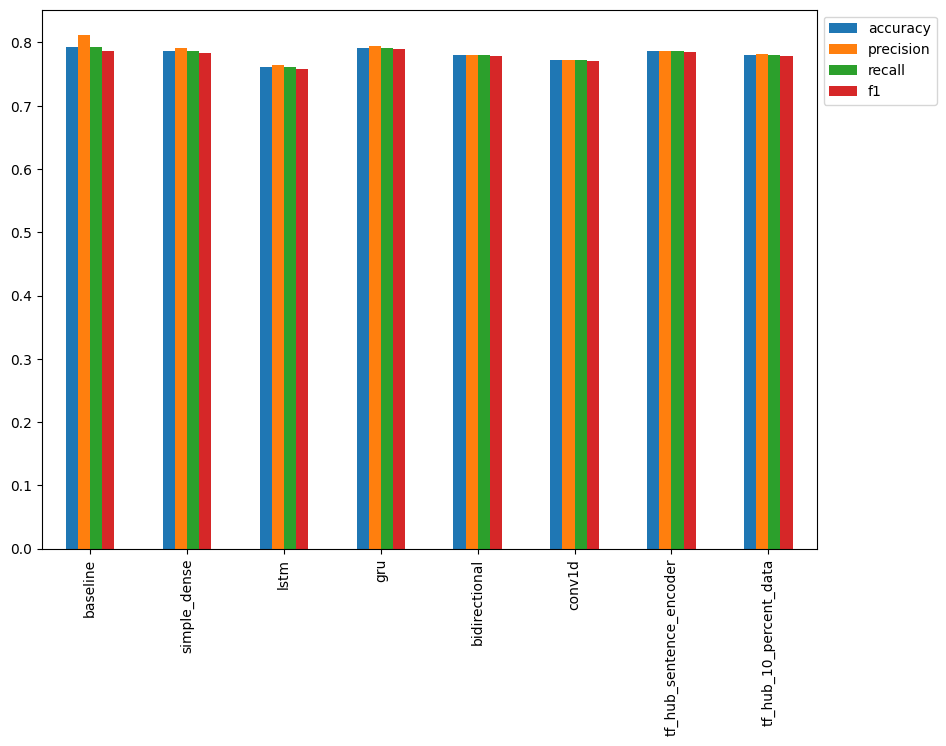

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

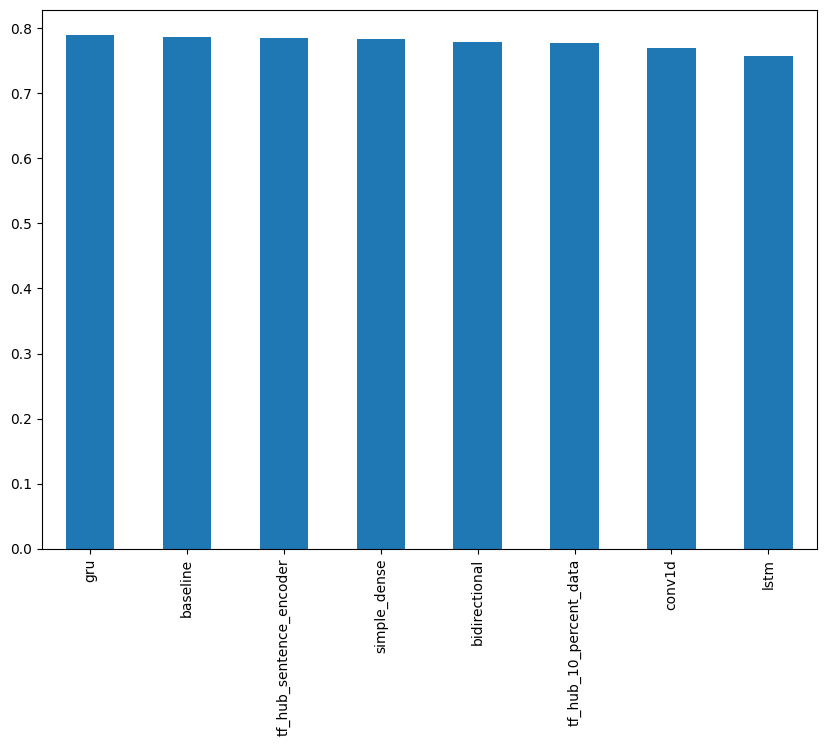

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### Find the most wrong examples

* If our best model still isnt perfect, then what examples is it getting wrong?
* And of these wrong examples which ones is it getting most wrong

In [ ]:
# Create DataFrame with validation sentences and best performing model predictions
if "08_model_6_USE_feature_extractor.zip" not in os.listdir("."):
    ! wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
    unzip_data("08_model_6_USE_feature_extractor.zip")

In [ ]:
# IMport previously trained model
# model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 30ms/step - loss: 0.4952 - accuracy: 0.7861


[0.49517935514450073, 0.7860892415046692]

In [ ]:
model_6_pretrained_pred_probs = model_6.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_results = calculate_results(val_labels,model_6_pretrained_preds)
model_6_pretrained_results

24/24 [==============================] - 1s 20ms/step


{'accuracy': 78.60892388451444,
 'precision': 0.7866474744348231,
 'recall': 0.7860892388451444,
 'f1': 0.78486500301026}

In [ ]:
val_df = pd.DataFrame({"test": val_sentences,
                        "target":val_labels,
                        "prediction":model_6_pretrained_preds,
                        "pred_probs":tf.squeeze(model_6_pretrained_pred_probs)})
val_df

,test,target,prediction,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.349365
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.669922
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.854980
3,@camilacabello97 Internally and externally scr...,1,0.0,0.340332
4,Radiation emergency #preparedness starts with ...,1,1.0,0.648926
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.274658
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.201904
759,FedEx will no longer transport bioterror patho...,0,1.0,0.702148
760,Crack in the path where I wiped out this morni...,0,1.0,0.545898


In [ ]:
# Find the wrong predictions and sort by prediction probability
most_wrong = val_df[val_df["target"]!=val_df["prediction"]].sort_values(by="pred_probs",ascending=False)

In [ ]:
most_wrong.head(10)

,test,target,prediction,pred_probs
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803711
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.760742
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.757812
181,Article by Michael Jackman at Metro Times Detr...,0,1.0,0.707031
759,FedEx will no longer transport bioterror patho...,0,1.0,0.702148
80,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,1.0,0.686523
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.673828
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.671875
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.669922
630,Hollywood movie about trapped miners released ...,0,1.0,0.665039


In [ ]:
most_wrong.tail(10)

,test,target,prediction,pred_probs
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.182495
382,I wanna set some shit on fire.,1,0.0,0.176025
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.169434
722,Indeed!! I am fully aware of that battle! I su...,1,0.0,0.166138
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.152710
352,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.151733
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.150269
681,'The way you move is like a full on rainstorm ...,1,0.0,0.148804
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.117004
233,I get to smoke my shit in peace,1,0.0,0.115112


In [ ]:
# Check the false poitives (predicted true but actually it is false)
for row in most_wrong[:5].itertuples():
    _, text,target,pred,pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text :\n {text}\n")
    print("-------------------\n")

Target: 0, Pred: 1.0, Prob: 0.8037109375
Text :
 @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

-------------------

Target: 0, Pred: 1.0, Prob: 0.7607421875
Text :
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-------------------

Target: 0, Pred: 1.0, Prob: 0.7578125
Text :
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

-------------------

Target: 0, Pred: 1.0, Prob: 0.70703125
Text :
 Article by Michael Jackman at Metro Times Detroit:
The group later downgraded the estimate to 37 square miles of... http://t.co/h31mmuduqt

-------------------

Target: 0, Pred: 1.0, Prob: 0.7021484375
Text :
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-------------------


In [ ]:
# Check the false negatives (predicted false but actually it is true)
for row in most_wrong[-5:].itertuples():
    _, text,target,pred,pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text :\n {text}\n")
    print("-------------------\n")

Target: 1, Pred: 0.0, Prob: 0.1517333984375
Text :
 @reriellechan HE WAS THE LICH KING'S FIRST CASUALTY BLOCK ME BACK I HATE YOU! http://t.co/0Gidg9U45J

-------------------

Target: 1, Pred: 0.0, Prob: 0.1502685546875
Text :
 Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

-------------------

Target: 1, Pred: 0.0, Prob: 0.1488037109375
Text :
 'The way you move is like a full on rainstorm and I'm a house of cards'

-------------------

Target: 1, Pred: 0.0, Prob: 0.11700439453125
Text :
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-------------------

Target: 1, Pred: 0.0, Prob: 0.1151123046875
Text :
 I get to smoke my shit in peace

-------------------


In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


### Making predictions of test dataset

In [ ]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences,5)
for x in test_samples:
    pred_probs = tf.squeeze(model_6.predict([x]))
    pred = (tf.round(pred_probs))
    print(f"Pred: {int(pred)}, Prob: {pred_probs}")
    print(f"Text: \n{x}\n")
    print("--------------------------\n")

1/1 [==============================] - 0s 228ms/step
Pred: 0, Prob: 0.315185546875
Text: 
Photo: bonesymcbones: Beartooth - Body Bag (x) http://t.co/kNH4HLFuMa

--------------------------

1/1 [==============================] - 0s 202ms/step
Pred: 1, Prob: 0.51806640625
Text: 
Job now are only in case of emergency.

--------------------------

1/1 [==============================] - 0s 211ms/step
Pred: 0, Prob: 0.412353515625
Text: 
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/a0zgzd1fYa #prebreak #best

--------------------------

1/1 [==============================] - 0s 244ms/step
Pred: 0, Prob: 0.306396484375
Text: 
@CatholicMomVA Or take away his ring &amp; throw it in a volcano...

--------------------------

1/1 [==============================] - 0s 248ms/step
Pred: 0, Prob: 0.403076171875
Text: 
Bat four reasons en route to upheaval versus internet buzz value: pVDRDLJvc

--------------------------


## The speed/score tradeoff

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
model_6_pretrained_results

{'accuracy': 78.60892388451444,
 'precision': 0.7866474744348231,
 'recall': 0.7860892388451444,
 'f1': 0.78486500301026}

In [ ]:
# Create a function to measure time of prediction
import time
def pred_time(model,samples):
    start = time.perf_counter()
    model.predict(samples)
    stop = time.perf_counter()
    total_time = stop-start
    time_per_pred = total_time/len(samples)
    return total_time,time_per_pred

In [ ]:
model_6_pretrained_time = pred_time(model_6,val_sentences)
model_6_pretrained_time

24/24 [==============================] - 4s 160ms/step


(4.06398299400098, 0.005333311015749318)

In [ ]:
baseline_time = pred_time(model_0,val_sentences)
baseline_time

(0.07959060900066106, 0.00010444961811110375)

In [ ]:
model_6_pretrained_results

{'accuracy': 78.60892388451444,
 'precision': 0.7866474744348231,
 'recall': 0.7860892388451444,
 'f1': 0.78486500301026}

Text(0.5, 1.0, 'F1-Score versus time per prediction')

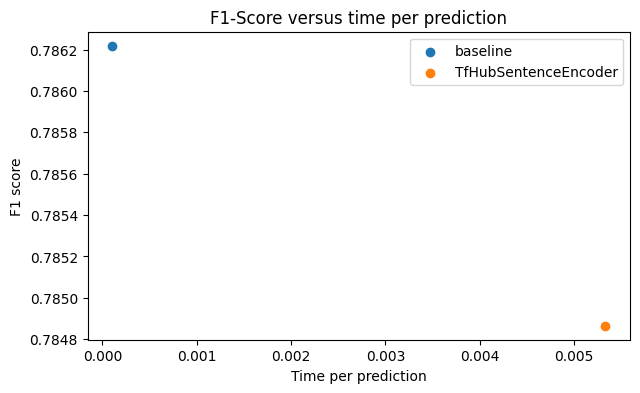

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.scatter(baseline_time[1],baseline_results["f1"],label="baseline")
plt.scatter(model_6_pretrained_time[1], model_6_pretrained_results["f1"],label="TfHubSentenceEncoder")
plt.legend()
plt.ylabel("F1 score")
plt.xlabel("Time per prediction")
plt.title("F1-Score versus time per prediction")

# Exercise

In [ ]:
#1. Rebuild, compile and train model_1, model_2 and model_5 using the Keras Sequential API instead of the Functional API.
#1.a
model_1_exercise = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])
model_1_exercise.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])
history_1_exercise = model_1_exercise.fit(train_sentences, train_labels,
                                     epochs=5,
                                     validation_data=(val_sentences, val_labels))
model_1_preds_exercise = model_1_exercise.predict(val_sentences)
calculate_results(val_labels, tf.squeeze(tf.round(model_1_preds_exercise)))

Epoch 1/5
  3/215 [..............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5000

I0000 00:00:1703430154.149104   67365 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 8s 30ms/step - loss: 0.6099 - accuracy: 0.6922 - val_loss: 0.5360 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4413 - accuracy: 0.8193 - val_loss: 0.4690 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3466 - accuracy: 0.8608 - val_loss: 0.4587 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2851 - accuracy: 0.8914 - val_loss: 0.4637 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 0s 2ms/step


{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [ ]:
#1.b
model_2_exercise = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])
model_2_exercise.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])
history_2_exercise = model_2_exercise.fit(train_sentences, train_labels,
                                     epochs=5,
                                     validation_data=(val_sentences, val_labels))
model_2_preds_exercise = model_2_exercise.predict(val_sentences)
calculate_results(val_labels, tf.squeeze(tf.round(model_2_preds_exercise)))

Epoch 1/5
215/215 [==============================] - 15s 54ms/step - loss: 0.2238 - accuracy: 0.9165 - val_loss: 0.5366 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1668 - accuracy: 0.9381 - val_loss: 0.5980 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1317 - accuracy: 0.9515 - val_loss: 0.7259 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1102 - accuracy: 0.9590 - val_loss: 0.8589 - val_accuracy: 0.7848
Epoch 5/5
24/24 [==============================] - 1s 7ms/step


{'accuracy': 78.08398950131233,
 'precision': 0.7828610537338687,
 'recall': 0.7808398950131233,
 'f1': 0.7787902197895524}

In [ ]:
#1.c
model_5_exercise = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])
model_2_exercise.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])
history_2_exercise = model_2_exercise.fit(train_sentences, train_labels,
                                     epochs=5,
                                     validation_data=(val_sentences, val_labels))
model_2_preds_exercise = model_2_exercise.predict(val_sentences)
calculate_results(val_labels, tf.squeeze(tf.round(model_2_preds_exercise)))

Epoch 1/5
215/215 [==============================] - 13s 44ms/step - loss: 0.0741 - accuracy: 0.9707 - val_loss: 0.8903 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0577 - accuracy: 0.9746 - val_loss: 1.3991 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0491 - accuracy: 0.9768 - val_loss: 1.6260 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0464 - accuracy: 0.9781 - val_loss: 1.3402 - val_accuracy: 0.7756
Epoch 5/5
24/24 [==============================] - 1s 8ms/step


{'accuracy': 76.77165354330708,
 'precision': 0.7681410880728078,
 'recall': 0.7677165354330708,
 'f1': 0.7662770891654436}

In [ ]:
#2. Retrain the baseline model with 10% of the training data. How does perform 
# compared to the Universal Sentence Encoder model with 10% of the training data?
train_sentences_10_percent = train_sentences[:int(0.1*len(train_sentences))]
train_labels_10_percent = train_labels[:int(0.1*len(train_labels))]
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences_10_percent, train_labels_10_percent)
model_0.score(val_sentences, val_labels)*100

70.20997375328083

In [ ]:
#3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.
sentence_encoder_layer = hub.KerasLayer(embed,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) #model is trainable now
model_fine_tune_exercise = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])
model_fine_tune_exercise.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])
history_fine_tune_exercise = model_fine_tune_exercise.fit(train_sentences, train_labels,
                                     epochs=1,
                                     validation_data=(val_sentences, val_labels))
model_fine_tune_preds_exercise = model_fine_tune_exercise.predict(val_sentences)
calculate_results(val_labels, tf.squeeze(tf.round(model_fine_tune_preds_exercise)))

I0000 00:00:1703425067.700393   40160 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 1s 22ms/step


{'accuracy': 81.49606299212599,
 'precision': 0.8153632818598993,
 'recall': 0.8149606299212598,
 'f1': 0.8150930383740584}

In [ ]:
#4 Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv
# Challenge, beat the baseline
model_best_exercise = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(128,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
model_best_exercise.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model_best_exercise_history = model_best_exercise.fit(train_df_shuffled.text, train_df_shuffled.target,
                                      epochs=10)

model_best_exercise_pred_probs = model_best_exercise.predict(test_df.text)
model_best_exercise_preds = tf.squeeze(tf.round(model_best_exercise_pred_probs))
model_best_exercise_preds = [int(pred) for pred in model_best_exercise_preds.numpy()]
test_df["target"] = model_best_exercise_preds
submission = test_df[["id", "target"]]
submission.to_csv("submission.csv", index=False)

Epoch 1/10
238/238 [==============================] - 6s 20ms/step - loss: 0.4717 - accuracy: 0.7908
Epoch 2/10
238/238 [==============================] - 5s 19ms/step - loss: 0.3938 - accuracy: 0.8291
Epoch 3/10
238/238 [==============================] - 4s 19ms/step - loss: 0.3661 - accuracy: 0.8428
Epoch 4/10
238/238 [==============================] - 4s 19ms/step - loss: 0.3336 - accuracy: 0.8614
Epoch 5/10
238/238 [==============================] - 4s 19ms/step - loss: 0.2943 - accuracy: 0.8824
Epoch 6/10
238/238 [==============================] - 5s 19ms/step - loss: 0.2502 - accuracy: 0.9033
Epoch 7/10
238/238 [==============================] - 5s 19ms/step - loss: 0.2054 - accuracy: 0.9243
Epoch 8/10
238/238 [==============================] - 5s 19ms/step - loss: 0.1591 - accuracy: 0.9460
Epoch 9/10
238/238 [==============================] - 5s 19ms/step - loss: 0.1255 - accuracy: 0.9594
Epoch 10/10
102/102 [==============================] - 2s 16ms/step


In [ ]:
#5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare 
# to averaging the prediction probabilities of each model?
#ensemble majority voting - take the preds which has max support
models=[model_1_preds, model_2_preds, model_3_preds, model_4_preds, model_5_preds, model_6_preds]
ensemble_preds_exercise=[]
for i in range(len(model_1_preds)):
    class0Count, class1Count = 0, 0
    for model in models:
        if model[i]==0:
            class0Count+=1
        elif model[i]==1:
            class1Count+=1
    if class0Count>class1Count:
        ensemble_preds_exercise.append(0)
    else:
        ensemble_preds_exercise.append(1)
calculate_results(val_labels, ensemble_preds_exercise)

{'accuracy': 79.79002624671917,
 'precision': 0.798940036341611,
 'recall': 0.7979002624671916,
 'f1': 0.7965988626421697}

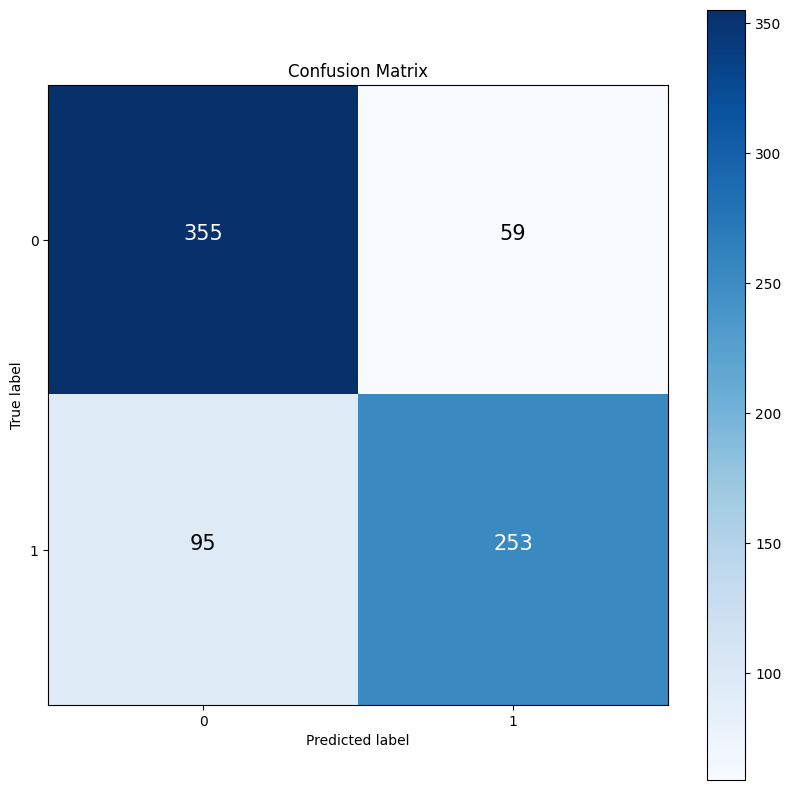

In [ ]:
#6. Make a confusion matrix with the best performing model's
#predictions on the validation set and the validation ground truth labels.
from helper_functions import make_confusion_matrix
make_confusion_matrix(val_labels, ensemble_preds_exercise)